<a href="https://colab.research.google.com/github/MohammadKatif/Custom-3D-CNN/blob/main/3D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
from google.colab import drive
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Creating custom dataset and dataloader for the 3D CNN in pytorch using the data obtained from Voxelization Method #1

class VoxelGridDataset(Dataset):
  def __init__(self, root_dir, mode, transform=None):
    self.root_dir = root_dir
    self.mode = mode
    self.transform = transform
    self.file_paths = []
    self.categories = []
    self.category_to_index = {}
    self.index_to_category = {}

    categories = os.listdir(root_dir)
    categories.sort()

    for idx, category in enumerate(categories):
      self.category_to_index[category] = idx
      self.index_to_category[idx] = category

    for category in categories:
      category_path = os.path.join(root_dir, category)
      category_mode_path = os.path.join(category_path, mode)
      for file in os.listdir(category_mode_path):
        self.file_paths.append(os.path.join(category_mode_path, file))
        self.categories.append(category)

  def __len__(self):
    return len(self.file_paths)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    voxel_grid_array = np.load(self.file_paths[idx])['arr_0']
    category = self.categories[idx]
    category_idx = self.category_to_index[category]

    if self.transform:
      voxel_grid_array = self.transform(voxel_grid_array)

    return voxel_grid_array, category_idx

class ToTensor(object):
  def __call__(self, voxel_grid_array):
    return torch.from_numpy(voxel_grid_array).float()

root_dir = '/content/drive/MyDrive/ModelNet10_arrays'

train_dataset = VoxelGridDataset(root_dir, mode='train', transform=ToTensor())
test_dataset = VoxelGridDataset(root_dir, mode='test', transform=ToTensor())

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # shuffle is set true to prevent overfitting
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # shuffle is set false for accurate and consistent evaluation

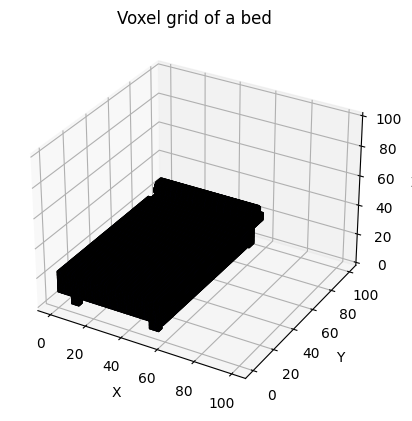

In [3]:
# Confirming whether the dataset is accurate or not

index = 414
voxel_grid_tensor, category_idx = train_dataset[index]
voxel_grid_array = voxel_grid_tensor.numpy()
category = train_dataset.index_to_category[category_idx]

fig = plt.figure()
ax = plt.axes(projection='3d')
voxels = voxel_grid_array.astype(bool)
ax.voxels(voxels, facecolor='b', edgecolor='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Voxel grid of a {category}')
plt.show()

In [4]:
# Confirming whether the dataloader works accurately or not

i = 0
for batch in train_dataloader:
  i += 1
  data, labels = batch
  if i == 1:
    if len(data) == len(labels):
      print(f'The data loader works accurately! ')
      data = data.unsqueeze(1)
      print(data.shape)
    else:
      print(f'The data loader does not works accurately :( )')
    break

The data loader works accurately! 
torch.Size([32, 1, 100, 100, 100])


In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [4]:
# Creating a 3D CNN with 3D convolutional and pooling layers
class CNN(nn.Module):
    def __init__(self):
      super(CNN, self).__init__()

      self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
      self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
      self.relu = nn.ReLU()
      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(32 * 25 * 25 * 25, 128)
      self.fc2 = nn.Linear(128, 10)  # ModelNet10 Dataset contains 10 different labels

    def forward(self, x):
      # input 1x100x100x100 output 1x50x50x50
      x = self.pool(x)
      # input 1x50x50x50 output 16x50x50x50
      x = self.relu(self.conv1(x))
      # input 16x50x50x50 output 32x50x50x50
      x = self.relu(self.conv2(x))
      # input 32x50x50x50 output 32x25x25x25
      x = self.pool(x)
      # input 32x25x25x25 output 500000
      x = self.flatten(x)
      # input 500000 output 128
      x = self.relu(self.fc1(x))
      # input 128 output 10
      x = self.fc2(x)
      return x

# Instantiating the model
model = CNN().to(device)

In [41]:
# Training the model

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epochs = 4
for epoch in range(epochs):
  samples = 0
  for data, labels in train_dataloader:
    data, labels = data.to(device), labels.to(device)
    data = data.unsqueeze(1) # Adding channel number(1) to the input data, which will become (32, 1, 100, 100, 100)
    predicted_labels = model(data)
    loss = loss_function(predicted_labels, labels)
    optimizer.zero_grad() # Resets the gradient of all model parameters to zero, otherwise the gradients will accumulate
    loss.backward() # Calculates the gradient of the loss function for each parameter of the model
    optimizer.step() # Gradient descent: Minimizes the loss caused by each parameter of a model. It does so by iteratively moving in the direction of the global minimum with a predefined step size (learning rate), optimizing/updating the parameter along the way.
    samples += len(labels)
    print(f'Progress: Epoch {epoch+1} - {(samples/len(train_dataset))*100} % Done!')

print('finished training') # Starting at 2:00 PM

Progress: Epoch 1 - 0.8018040591330494 % Done!
Progress: Epoch 1 - 1.6036081182660988 % Done!
Progress: Epoch 1 - 2.405412177399148 % Done!
Progress: Epoch 1 - 3.2072162365321977 % Done!
Progress: Epoch 1 - 4.009020295665247 % Done!
Progress: Epoch 1 - 4.810824354798296 % Done!
Progress: Epoch 1 - 5.612628413931345 % Done!
Progress: Epoch 1 - 6.414432473064395 % Done!
Progress: Epoch 1 - 7.216236532197444 % Done!
Progress: Epoch 1 - 8.018040591330495 % Done!
Progress: Epoch 1 - 8.819844650463542 % Done!
Progress: Epoch 1 - 9.621648709596592 % Done!
Progress: Epoch 1 - 10.423452768729643 % Done!
Progress: Epoch 1 - 11.22525682786269 % Done!
Progress: Epoch 1 - 12.02706088699574 % Done!
Progress: Epoch 1 - 12.82886494612879 % Done!
Progress: Epoch 1 - 13.630669005261838 % Done!
Progress: Epoch 1 - 14.432473064394888 % Done!
Progress: Epoch 1 - 15.234277123527937 % Done!
Progress: Epoch 1 - 16.03608118266099 % Done!
Progress: Epoch 1 - 16.837885241794037 % Done!
Progress: Epoch 1 - 17.639

**Gradient descent algorithm:**

loss.backward() # Calculates gradient

optimizer.step() # *Optimizes*/ Updates the parameters of the model while iteratively moving in the direction of the global minimum.

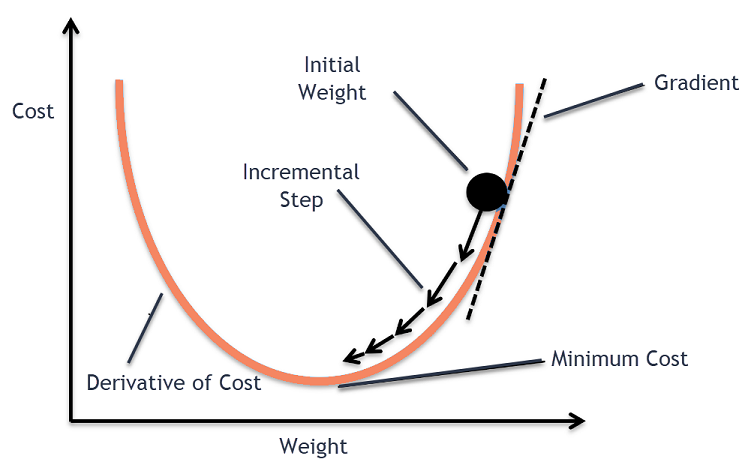

In [42]:
# Testing the model

total_samples = 0
correct_predictions = 0
samples = 0
model.eval()
with torch.no_grad():
  for data, labels in test_dataloader:
    data, labels = data.to(device), labels.to(device)
    data = data.unsqueeze(1)
    predicted_labels = model(data)
    predicted_labels = predicted_labels.argmax(dim=1)
    total_samples += len(labels)
    for i in range(len(labels)):
      if predicted_labels[i] == labels[i]:
        correct_predictions += 1
    samples += len(labels)
    print(f'Progress: {(samples/len(test_dataset))*100} % Done!')

accuracy = (correct_predictions / total_samples) * 100
print(f"Accuracy: {accuracy}%")

Progress: 3.524229074889868 % Done!
Progress: 7.048458149779736 % Done!
Progress: 10.572687224669604 % Done!
Progress: 14.096916299559473 % Done!
Progress: 17.62114537444934 % Done!
Progress: 21.145374449339208 % Done!
Progress: 24.669603524229075 % Done!
Progress: 28.193832599118945 % Done!
Progress: 31.718061674008812 % Done!
Progress: 35.24229074889868 % Done!
Progress: 38.76651982378855 % Done!
Progress: 42.290748898678416 % Done!
Progress: 45.81497797356828 % Done!
Progress: 49.33920704845815 % Done!
Progress: 56.38766519823789 % Done!
Progress: 59.91189427312775 % Done!
Progress: 63.436123348017624 % Done!
Progress: 66.96035242290749 % Done!
Progress: 70.48458149779736 % Done!
Progress: 74.00881057268722 % Done!
Progress: 77.5330396475771 % Done!
Progress: 81.05726872246696 % Done!
Progress: 84.58149779735683 % Done!
Progress: 88.10572687224669 % Done!
Progress: 91.62995594713657 % Done!
Progress: 95.15418502202643 % Done!
Progress: 98.6784140969163 % Done!
Progress: 100.0 % Done

In [ ]:
# Saving the trained model

torch.save(model.state_dict(), 'model_parameters.pth')

In [ ]:

index = 99 # Max 907

voxel_grid_tensor, label_idx = test_dataset[index]
voxel_grid_array = voxel_grid_tensor.numpy()
category = test_dataset.index_to_category[label_idx]

model.eval()
model.to(device)
with torch.no_grad():
  input = voxel_grid_tensor.unsqueeze(0).unsqueeze(0).to(device)
  predicted_label = model(input)
  predicted_label = predicted_label.argmax(dim=1)
  predicted_label = predicted_label.cpu().numpy().item()
  predicted_category = test_dataset.index_to_category[predicted_label]
  print(f'Predicted Category: {predicted_category} \nActual Category: {category}')

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.voxels(voxel_grid_array, edgecolor='k')
ax.set_title(f'Voxel grid array of {category}')
plt.show()

Predicted Category: bed 
Actual Category: bed


In [44]:
print(len(test_dataset))

908
